In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint

from py_analyze_tools.sklearn import BasisFunctionConfiguration, ReaDDyElasticNetEstimator

from scipy.integrate import odeint
import numpy as np
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from pathos.multiprocessing import Pool
from sklearn.model_selection import KFold
import itertools

In [7]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:]
traj.update()

traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 6000.0, min nonzero counts = 1.0
max counts = 4202.0, min nonzero counts = 825.0


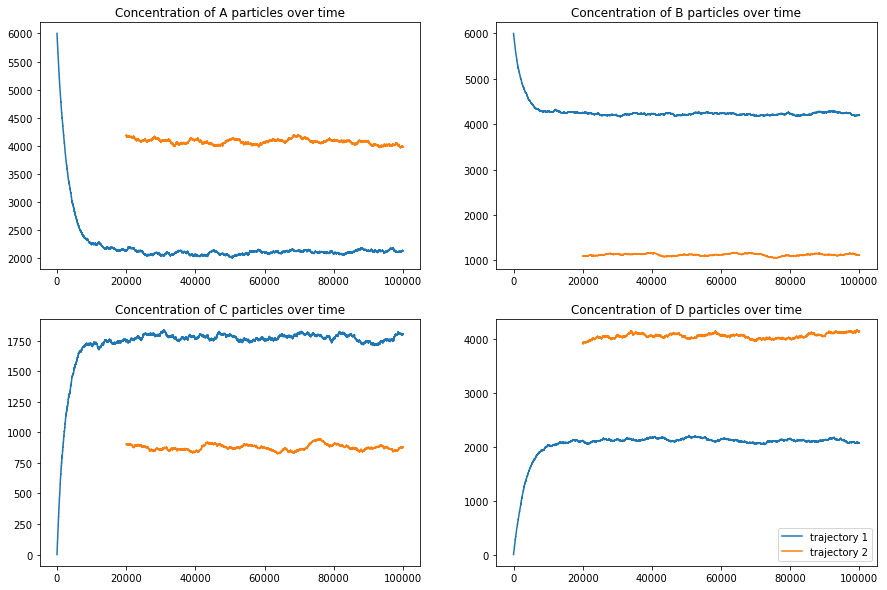

In [9]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps), traj.counts[:, i], label="trajectory 1")
    axes[i].plot(np.arange(0, traj2.n_time_steps)+20000, traj2.counts[:, i], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

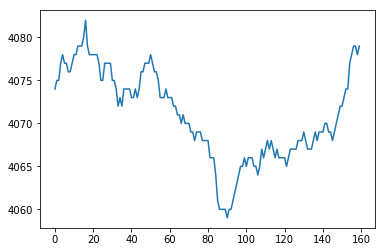

In [4]:
plt.plot(np.arange(0, traj2.n_time_steps//500), traj2.counts[10000:10000+traj2.n_time_steps//500, 0])

# cross validation within trajectory 2 using k-fold

In [5]:
class CVResult(object):
    
    def __init__(self, alpha, l1_ratio, estimator):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.estimator = estimator
        self.scores = []
        
    def add_score(self, score):
        self.scores.append(score)

In [44]:
class CV(object):
    
    def __init__(self, traj, bfc, scale, alphas, l1_ratios, n_splits, init_xi, n_jobs=8, show_progress=True, 
                 mode='k_fold', verbose=False):
        self.alphas = alphas
        self.l1_ratios = l1_ratios
        self.n_jobs = n_jobs
        self.n_splits = n_splits
        self.traj = traj
        self.bfc = bfc
        self.scale = scale
        self.show_progress = show_progress
        self.result = []
        self.init_xi = init_xi
        self.mode = mode
        self.verbose = verbose
        
    def compute_cv_result(self, params):
        if self.mode == 'k_fold':
            kf = KFold(n_splits=self.n_splits)
        elif self.mode == 'time_series_split':
            kf = TimeSeriesSplit(n_splits=self.n_splits)
        else:
            print("unknown mode: %s" % self.mode)
            return
        alpha, l1_ratio = params
        estimator = ReaDDyElasticNetEstimator(self.traj, self.bfc, self.scale, alpha=alpha, 
                                              l1_ratio=l1_ratio, init_xi=self.init_xi, verbose=self.verbose)
        scores = []
        for train_idx, test_idx in kf.split(range(0, self.traj.n_time_steps)):
            estimator.fit(train_idx)
            scores.append(estimator.score(test_idx, traj.dcounts_dt[test_idx]))
        return {'scores': scores, 'alpha': alpha, 'l1_ratio': l1_ratio}
        
    def fit(self):
        params = itertools.product(self.alphas, self.l1_ratios)
        result = []
        if self.show_progress:
            from ipywidgets import IntProgress
            from IPython.display import display
            f = IntProgress(min=0, max=len(self.alphas)*len(self.l1_ratios)-1)
            display(f)
        with Pool(processes=self.n_jobs) as p:
            for idx, res in enumerate(p.imap_unordered(self.compute_cv_result, params, 1)):
                result.append(res)
                if self.show_progress:
                    f.value = idx
        f.close()
        self.result = result

In [13]:
def get_dense_params(traj, bfc, scale, n_initial_values=16, n_jobs=8, initial_value=None):
    from ipywidgets import IntProgress
    from IPython.display import display
    if initial_value is not None:
        n_initial_values = 1
        initial_values = [initial_value]
    else:
        initial_values = [np.random.random(bfc.n_basis_functions) for _ in range(n_initial_values)]
    
    f = IntProgress(min=1, max=n_initial_values)
    display(f)
    coeffs = []
    def worker(init_xi):
        est = ReaDDyElasticNetEstimator(traj, bfc, scale, alpha=0, l1_ratio=1.0, init_xi=init_xi, verbose=False)
        est.fit(range(0, traj.n_time_steps))
        return est.coefficients_
    
    coeffs = []
    with Pool(processes=n_jobs) as p:
        for idx, coeff in enumerate(p.imap_unordered(worker, initial_values, 1)):
            coeffs.append(coeff)
            f.value = idx+1
    f.close()
    return coeffs

In [8]:
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=5)
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
coeffs = get_dense_params(traj2, bfc, scale, n_jobs=8, n_initial_values=64)

In [ ]:
print("estimated coefficients:")

mean, std = np.mean(np.array(coeffs), axis=0), np.std(np.array(coeffs), axis=0)
print("mean=%s" % mean)
print("std=%s" % std)

estimated coefficients:
mean=[  3.61993351e-05   1.04363877e-08   6.01515634e-08   3.52368776e-04
   1.90786933e-01   8.49091576e-02   1.15251092e-05   1.29463909e-01
   2.15718538e-01]
std=[  5.85488519e-05   1.52891741e-08   9.90316929e-08   7.54490840e-04
   3.08534951e-01   1.82039989e-01   7.11383363e-05   2.66111113e-01
   3.55357493e-01]


In [ ]:
traj_tmp = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_tmp.counts = traj2.counts[20000:30000]
traj_tmp.update()

mean = np.array([  1.83750827e-05, 1.65500856e-07, 5.46281945e-08, 1.42029075e-05, 9.25337325e-02, 5.00634680e-02, 3.13310466e-04, 9.54048258e-02, 1.47596956e-01])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, mean)
cv.fit()

max counts = 4145.0, min nonzero counts = 835.0


In [17]:
for r in cv.result:
    print("alpha={}, l1_ratio={} -> scores={}".format(r['alpha'], r['l1_ratio'], r['scores']))

alpha=200.0, l1_ratio=1.0 -> scores=[-4052.605858940834, -4176.951146911881, -4099.842277431796, -4104.24958695623, -4148.33979850217, -4387.333153260505, -4185.854877067354, -4213.483828754421, -4252.350469930546, -4217.353894024625, -4222.254619158581, -4083.7938405462214, -4180.339364469088, -4160.067255965612, -4206.719150337161, -4337.772494614553, -4161.830116030559, -4296.182950678123, -4158.374077170176, -4167.738521884535, -4161.092546108527, -4260.054511856329, -4261.280158210281, -4379.787393251177, -4083.683199825781, -4263.312244204213, -4088.7301069110067, -4260.10113040171, -4112.8271111782005, -4296.356766846384, -4460.417657727567, -4254.689383968724, -4303.7479833850075, -4098.280816865702, -4116.366402936252, -4254.745742703546, -4270.694417476569, -4210.115933281628, -4177.92043385453, -4227.213568894767, -4001.3693387046837, -4231.972463460704, -4154.844129898459, -4229.070485795446, -4082.7144244757687, -4147.70151597745, -4138.584879658, -4239.155107064671, -4204

In [28]:
# blab = best_alpha, best_l1 = 0, 0
best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']

In [29]:
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

best alpha=800.0, best l1_ratio=1.0 with score=-4184.71647784


In [69]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
    
if False:
    # now estimate the coefficients with these parameters on equlibrated trajectory
    coefficients = []
    initial_values = [np.random.random(bfc.n_basis_functions) for _ in range(5)]
    for init_xi in initial_values:
        best_estimator = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, 
                                                   alpha=best_alpha, l1_ratio=best_l1, init_xi=init_xi)
        best_estimator.fit(range(0, traj_equilibrated.n_time_steps))
        coefficients.append((init_xi, best_estimator.coefficients_))
else:
    # estimate by the init xi used in the cross validation
    est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=best_alpha, l1_ratio=best_l1, init_xi=mean)
    est.fit(range(0, traj_equilibrated.n_time_steps))
    coefficients = [(mean, est.coefficients_)]

max counts = 4202.0, min nonzero counts = 825.0


In [70]:
print(mean)

[  1.83750827e-05   1.65500856e-07   5.46281945e-08   1.42029075e-05
   9.25337325e-02   5.00634680e-02   3.13310466e-04   9.54048258e-02
   1.47596956e-01]


max counts = 9000.0, min nonzero counts = 1.0


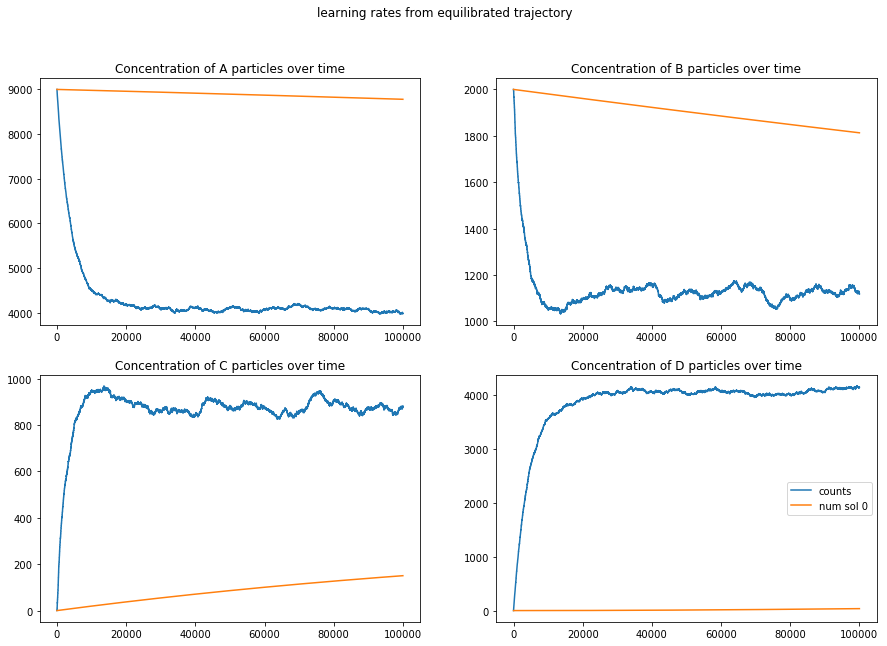

In [71]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for _, coeffs in coefficients:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## learn from equilibrium with right initial conditions

In [72]:
right_rates = np.array([1.96008738e-06,0,0,0,9.94587054e-03,0,0,1.00520362e-02,9.84303477e-03])

In [ ]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

alphas = np.linspace(0, 1000, num=16)
l1_ratios = np.linspace(0, 1, num=1) + 1
print("looking in a (alphas) x (l1_ratios) = %s x %s grid with alpha in [%s, %s] and l1_ratios in [%s, %s]" % (len(alphas), len(l1_ratios), alphas[0], alphas[-1], l1_ratios[0], l1_ratios[-1]))
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, right_rates)
cv.fit()

max counts = 4202.0, min nonzero counts = 825.0
looking in a (alphas) x (l1_ratios) = 16 x 1 grid with alpha in [0.0, 1000.0] and l1_ratios in [1.0, 1.0]


In [78]:
best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

best alpha=933.333333333, best l1_ratio=1.0 with score=-4170.10197684


In [ ]:
best_alpha, l1_ratio = 800, 1.0

In [79]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates)
est.fit(range(0, traj_equilibrated.n_time_steps))
coefficients = est.coefficients_

max counts = 4202.0, min nonzero counts = 825.0


In [80]:
print(coefficients)

[  8.52650786e-09   4.87440448e-08   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


max counts = 9000.0, min nonzero counts = 1.0


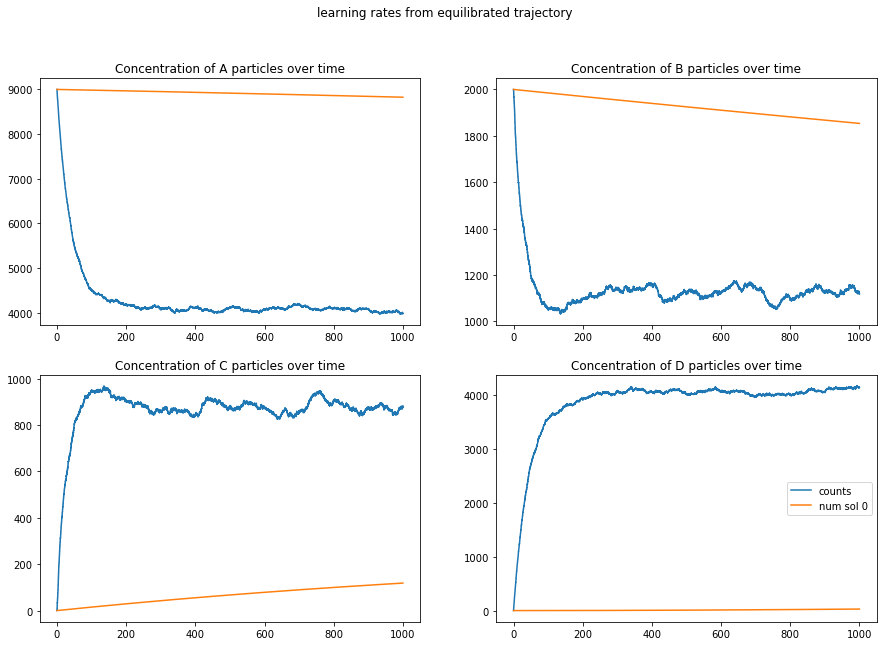

In [82]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
xs = np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], xs))
for i in range(full_traj.n_species):
    axes[i].plot(xs, full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(xs, num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## learn from equilibrium with the right set of basis functions

In [83]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
#bfc.add_fusion(0, 2, 3)  # A + C -> D
#bfc.add_fusion(0, 3, 2)  # A + D -> C
#bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
#bfc.add_fission(0, 1, 2) # A -> B + C
#bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 4202.0, min nonzero counts = 825.0


In [84]:
right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 50, right_rates)
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

best alpha=200.0, best l1_ratio=0.5 with score=-4170.08022211


In [99]:
traj_equilibrated = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj_equilibrated.counts = traj_equilibrated.counts[20000:]
traj_equilibrated.update()
est = ReaDDyElasticNetEstimator(traj_equilibrated, bfc, scale, alpha=.0, l1_ratio=best_l1, init_xi=right_rates)
est.fit(range(0, traj_equilibrated.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

max counts = 4202.0, min nonzero counts = 825.0
coefficients=[  8.76199851e-09   0.00000000e+00   6.86922262e-11   0.00000000e+00]


max counts = 9000.0, min nonzero counts = 1.0


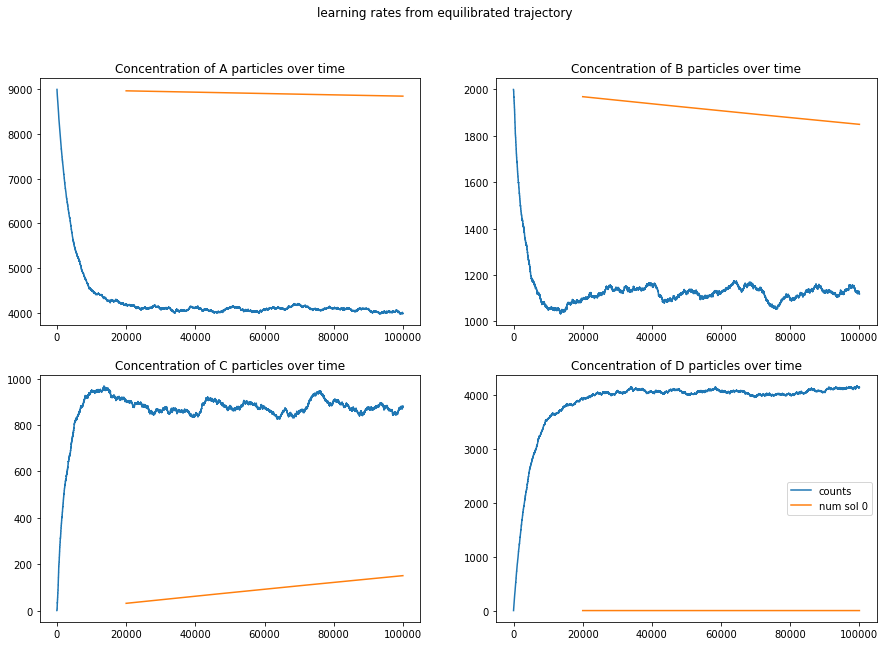

In [101]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
num_solns[0] = num_solns[0][20000:]
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(20000, 20000+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## use smaller timestep (tile counts)

In [20]:
traj2 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj2.counts = traj2.counts[20000:]
traj2.counts = traj2.counts.repeat(10, axis=0)
traj2.time_step = traj2.time_step / 10.
traj2.update()

bfc = BasisFunctionConfiguration(n_species=4)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)

max counts = 4202.0, min nonzero counts = 825.0


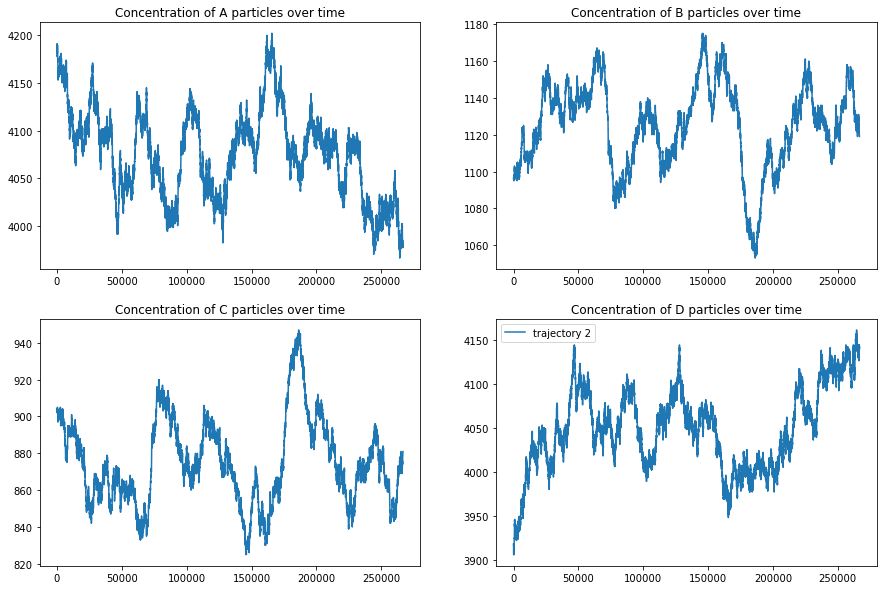

In [21]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj2.n_species):
    axes[i].plot(traj2.counts[:, i][::3], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

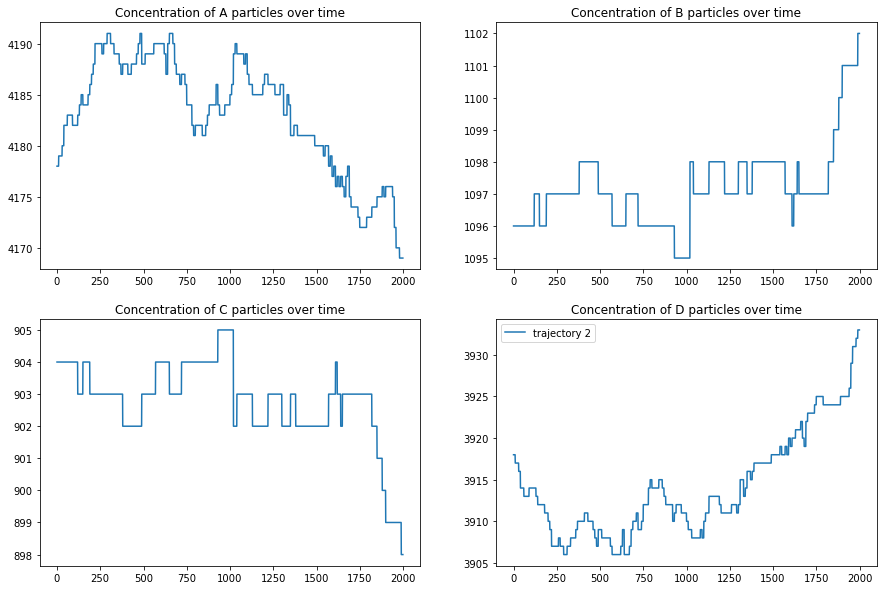

In [27]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
for i in range(traj2.n_species):
    axes[i].plot(traj2.counts[:, i][:20000//10], label="trajectory 2")
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

In [28]:
old_counts = np.copy(traj2.counts)

traj2.counts = traj2.counts[:20000]
traj2.update()

right_rates = np.array([1.96008738e-06,9.94587054e-03,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj2.n_species * traj2.n_time_steps)
cv = CV(traj2, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj2.counts = old_counts
traj2.update()

max counts = 4191.0, min nonzero counts = 877.0


best alpha=800.0, best l1_ratio=1.0 with score=-4920.31190446
max counts = 4202.0, min nonzero counts = 825.0


In [29]:
est = ReaDDyElasticNetEstimator(traj2, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj2.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

coefficients=[  1.89420448e-06   9.98416084e-03   1.00520361e-02   1.00452013e-02]


max counts = 9000.0, min nonzero counts = 1.0


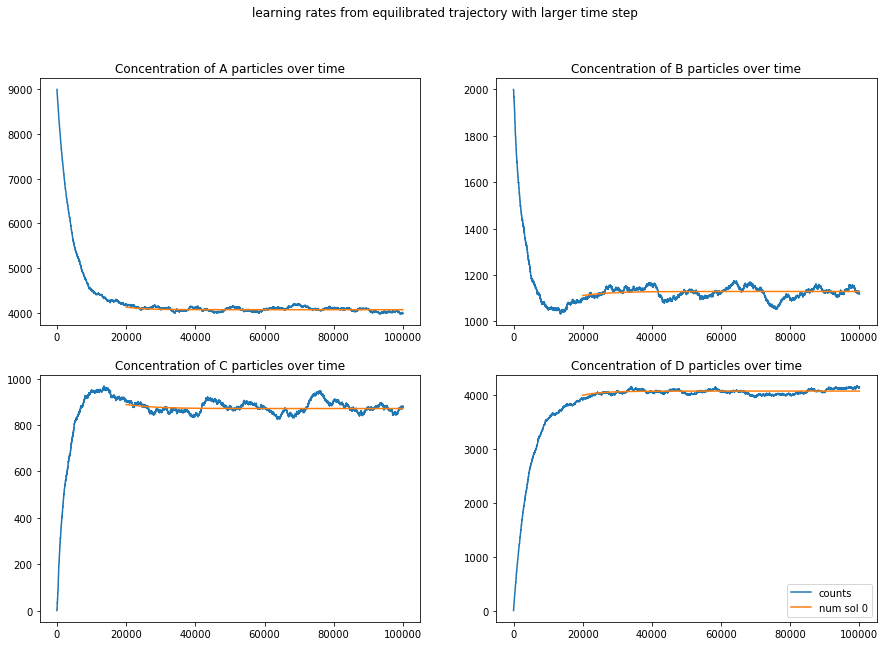

In [32]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
num_solns[0] = num_solns[0][20000:]
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(20000, 20000+len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## more ambiguity

In [37]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

max counts = 4202.0, min nonzero counts = 825.0


In [38]:
old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1.96008738e-06,0,0,0,9.94587054e-03,0,0,1.00520362e-02,9.84303477e-03])
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

max counts = 4191.0, min nonzero counts = 877.0


best alpha=1000.0, best l1_ratio=1.0 with score=-4921.10174494
max counts = 4202.0, min nonzero counts = 825.0


In [39]:
est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

coefficients=[  1.89168689e-06   0.00000000e+00   0.00000000e+00   1.23892160e-08
   9.98581351e-03   4.63959200e-06   0.00000000e+00   1.00530299e-02
   1.00540123e-02]


max counts = 9000.0, min nonzero counts = 1.0


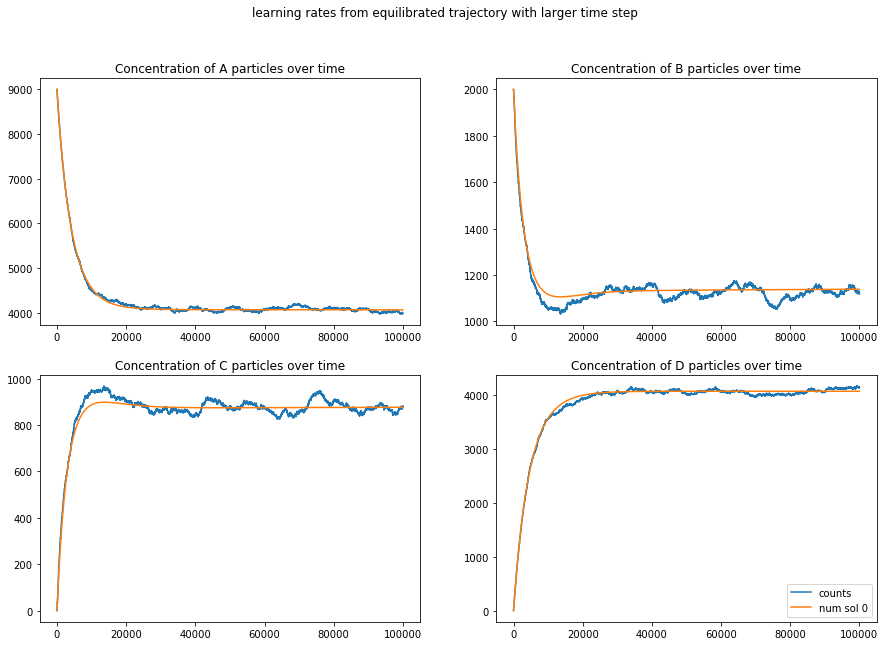

In [41]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## even more ambiguity and wrong initial conditions

In [42]:
traj3 = pat.Trajectory("../generate/simple_trajectory_3.h5")
traj3.counts = traj3.counts[20000:]
traj3.counts = traj3.counts.repeat(10, axis=0)
traj3.time_step = traj3.time_step / 10.
traj3.update()

bfc = BasisFunctionConfiguration(n_species=traj3.n_species)
bfc.add_fusion(0, 1, 2)  # A + B -> C (0)
bfc.add_fusion(0, 2, 3)  # A + C -> D
bfc.add_fusion(0, 3, 2)  # A + D -> C
bfc.add_fusion(1, 2, 3)  # B + C -> D 
bfc.add_fission(2, 0, 1) # C -> A + B (4)
bfc.add_fission(0, 1, 2) # A -> B + C
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(0, 3) # A -> D     (7)
bfc.add_conversion(3, 0) # D -> A     (8)
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(1, 2) # B -> C
#bfc.add_conversion(2, 3) # C -> D

old_counts = np.copy(traj3.counts)

traj3.counts = traj3.counts[:20000]
traj3.update()

right_rates = np.array([1e-3]*bfc.n_basis_functions)
alphas = np.linspace(0, 1000, num=6)
l1_ratios = np.linspace(0, 1, num=3) 
scale = 1. / (2. * traj3.n_species * traj3.n_time_steps)
cv = CV(traj3, bfc, scale, alphas, l1_ratios, 10, right_rates, mode='k_fold')
cv.fit()

best_score = np.mean(cv.result[0]['scores'])
for r in cv.result:
    if np.mean(r['scores']) > best_score:
        best_score = np.mean(r['scores'])
        best_alpha, best_l1 = r['alpha'], r['l1_ratio']
print("best alpha=%s, best l1_ratio=%s with score=%s" % (best_alpha, best_l1, best_score))

traj3.counts = old_counts
traj3.update()

est = ReaDDyElasticNetEstimator(traj3, bfc, scale, 
                                alpha=best_alpha, l1_ratio=best_l1, init_xi=right_rates, verbose=True)
est.fit(range(0, traj3.n_time_steps))
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)

max counts = 4202.0, min nonzero counts = 825.0
max counts = 4191.0, min nonzero counts = 877.0


best alpha=1000.0, best l1_ratio=0.5 with score=-4921.11526068
max counts = 4202.0, min nonzero counts = 825.0
coefficients=[  9.02637311e-08   1.98791187e-08   0.00000000e+00   1.37644069e-06
   4.85162754e-04   3.38263123e-04   1.29874721e-06   3.46977974e-04
   6.40752406e-04]


max counts = 9000.0, min nonzero counts = 1.0


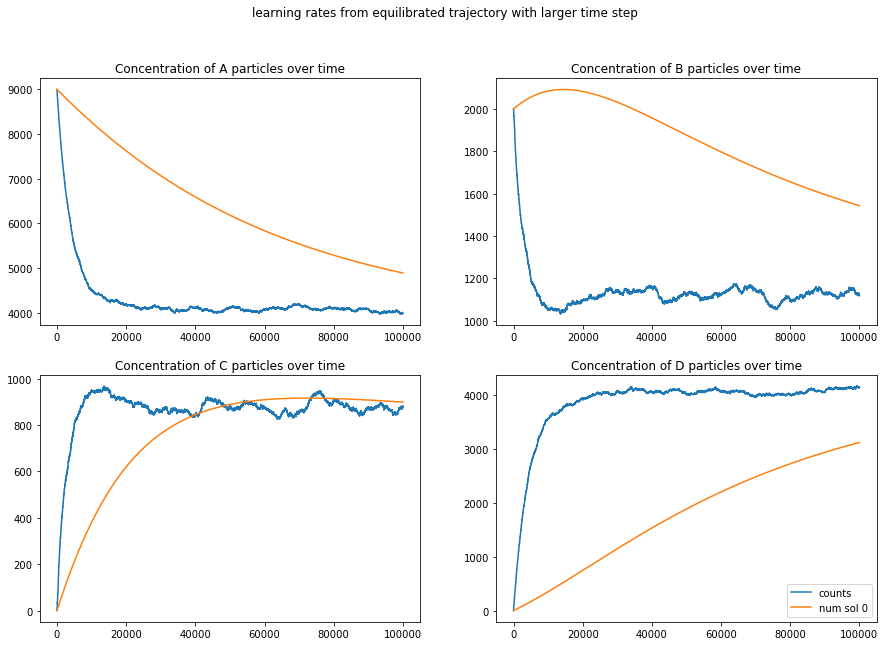

In [43]:
full_traj = pat.Trajectory("../generate/simple_trajectory_3.h5")
full_traj.update()

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
f.suptitle("learning rates from equilibrated trajectory with larger time step")
axes = [ax1, ax2, ax3, ax4]
labels=["A", "B", "C", "D"]
num_solns = []
for coeffs in [coefficients]:
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(coeffs, theta)
    num_solns.append(odeint(fun, full_traj.counts[0], np.arange(0, full_traj.n_time_steps*full_traj.time_step, full_traj.time_step)))
for i in range(full_traj.n_species):
    axes[i].plot(np.arange(0, full_traj.n_time_steps), full_traj.counts[:,i], label="counts")
    for idx, num_sol in enumerate(num_solns):
        axes[i].plot(np.arange(0, len(num_sol[:, i])), num_sol[:, i], label="num sol %s" % idx)
    axes[i].set_title("Concentration of %s particles over time" % labels[i])
plt.legend()
plt.show()

## maybe the derivative isn't right because it only does finite differences

## fit dense solution by least squares w sparse matrices and coupling conditions